# Mathematical methods for bioengineers - Coursework 3
Victoire de Saléon-Terras - January 2023

Here are the different libraries and functions used for the study:

In [1]:
import numpy as np
import scipy.io as io
import matplotlib.pyplot as plt
from scipy import signal
from scipy.signal import argrelextrema

## 1. Cell events
### 1.1. Loading the dataset

In [2]:
datadir = 'data/dataset3_m62/'

trackdata = io.loadmat(datadir+'downTrackdata.mat')
phi = trackdata['phi']
x = trackdata['x']
y = trackdata['y']
r_ = trackdata['r']
speed = trackdata['speed']
t = trackdata['time']

spikedata = io.loadmat(datadir+'spikes.mat')
spikes = spikedata['spikes']
params = spikedata['params']

fluodata = io.loadmat(datadir+'fissa_output.mat')
dFonF = fluodata['ddf_f'] # fluorescence time-series variable

### 1.2. Some useful parameters

In [3]:
n,N = dFonF.shape             # number of cells x number of frames
fs = 30.92                    # sampling rate (in Hz)
dt=1/fs                       # time intervall between 2 frames (in s)
t = np.linspace(0,N/fs,N)     # time (in s)
cell_ID = [0,1,2]             # cell ID of the cells to plot
offset=70                     # offset between time series on the plot

### 1.3. Smoothing the signal

In graph showed in this section, we observe that the fluorescence time series is noisy. This can affect the detection of firing events. To remove the noise in all the fluorescence time series, we apply a high pass (Butterworth) filter to all the dataset, to obtain the noise of all the neurons signals, and then we subtract the filtered values to the dataset (the quickest variations of the fluoresence time series in consecutive frames are mostly due to noise). Then we create a new variable with the smoothed fluorescence time series for each cell: dFonF_s

(reference for the high pass function: https://docs.scipy.org/doc/scipy/reference/generated/scipy.signal.butter.html)

The chosen cutoff frequency is $0.1 Hz$, then we normalize this frequency with half of the frame rate (Nyquist frequency), and we use this value in the 2nd order high pass filter.

In [4]:
def hp_filtering(dFonF,cutoff=0.1):
    b,a = signal.butter(2, cutoff/(0.5*fs), btype='high', analog=False)
    dFonF_s = np.zeros(np.shape(dFonF))
    for i in range(n):
        dFonF_s[i,:] = dFonF[i,:]-signal.filtfilt(b,a, dFonF[i,:])
    return dFonF_s

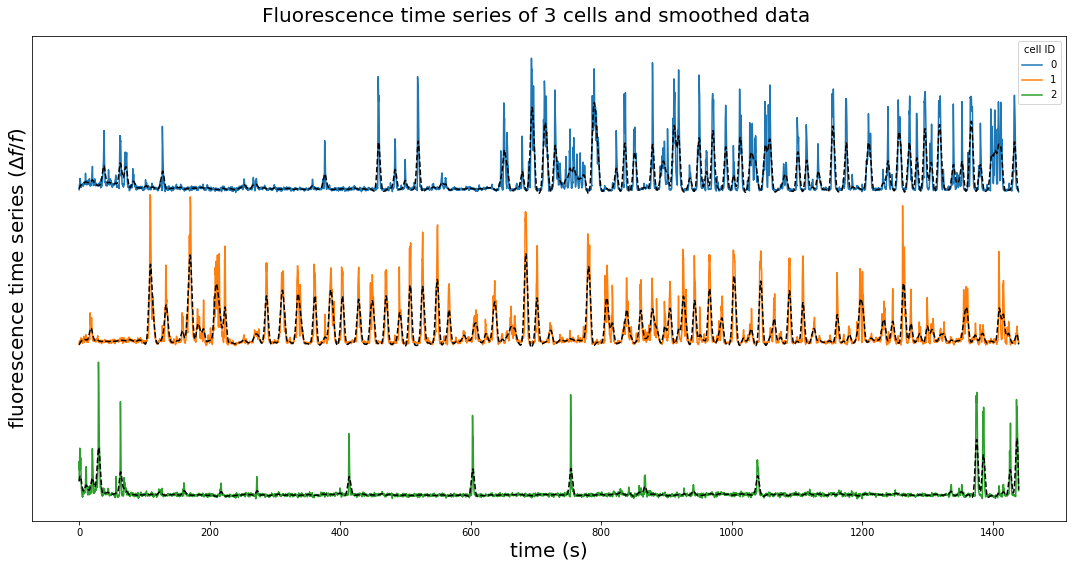

In [5]:
dFonF_s = hp_filtering(dFonF,cutoff=0.1)

fig,ax1 = plt.subplots(figsize=(15,8))
for i in range(len(cell_ID)):
    ax1.plot(t,dFonF[cell_ID[i],:]-offset*i,label=str(cell_ID[i]))
    filtered = dFonF_s[cell_ID[i],:]
    ax1.plot(t,filtered-offset*i,'k--')
ax1.set_yticks([])
ax1.set_xlabel('time (s)',fontsize=20)
ax1.set_ylabel("fluorescence time series ($\Delta f/f$)",fontsize=20)
ax1.legend(title='cell ID',loc='upper right')
plt.suptitle('Fluorescence time series of 3 cells and smoothed data',fontsize=20)
plt.tight_layout()
plt.show()

The raw fluorescence data is ploted in color above. We have superimposed in dotted line the smoothed data.
### 1.4. Derivative of the dataset
We need to detect the beginning of the firing events. The beginning of a firing event is characterised by a strong growth in the fluorescence time series. As a result, we can find the beginnings of the events by looking for the maximum of the derivatives of the fluorescence time series. The derivative function is written below:

$dFonF_d(t)=\frac{dFonF(t+dt)-dFonF(t)}{dt}$



In [6]:
def signal_diff(dFonF,dt=dt):
    dFonF_d = np.zeros(np.shape(dFonF))
    for i in range(n):
        dFonF_d[i,:-1]=(dFonF[i,1:]-dFonF[i,:-1])/dt
    return dFonF_d

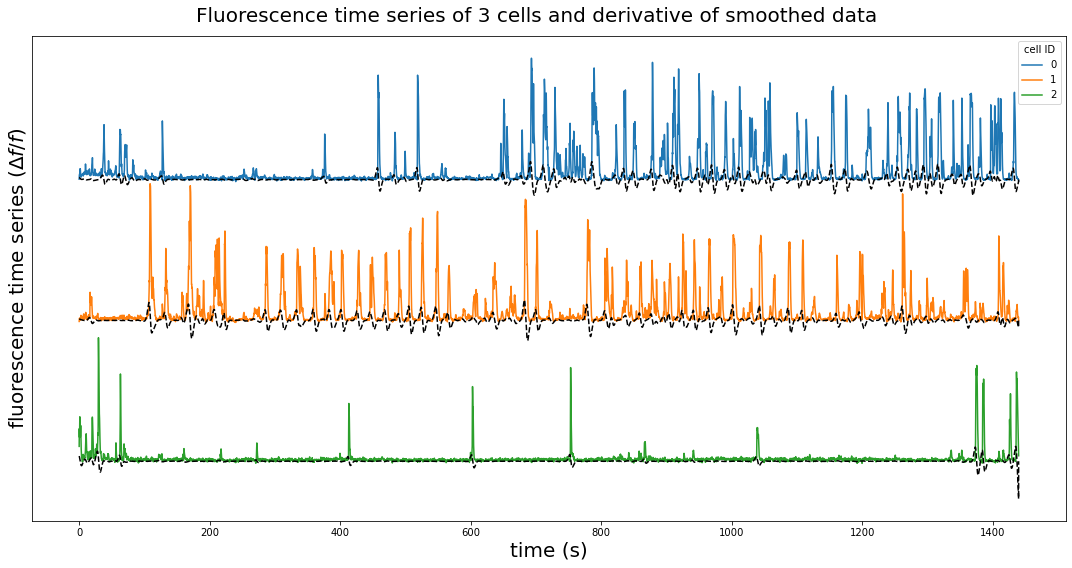

In [7]:
dFonF_d = signal_diff(dFonF_s,dt=dt)

fig,ax1 = plt.subplots(figsize=(15,8))
for i in range(len(cell_ID)):
    ax1.plot(t,dFonF[cell_ID[i],:]-offset*i,label=str(cell_ID[i]))
    diff = dFonF_d[cell_ID[i],:]
    ax1.plot(t,diff-offset*i,'k--')
ax1.set_yticks([])
ax1.set_xlabel('time (s)',fontsize=20)
ax1.set_ylabel("fluorescence time series ($\Delta f/f$)",fontsize=20)
ax1.legend(title='cell ID',loc='upper right')
plt.suptitle('Fluorescence time series of 3 cells and derivative of smoothed data',fontsize=20)
plt.tight_layout()
plt.show()

The raw fluorescence data is ploted in color above. We have superimposed in dotted line the derivative of the smoothed data.
### 1.5. Finding the beginning of events
As explained in the previous section, it only remains to find the local maximas of the derivative of the smoothed data. As little noise may remain, we added a threshold $tr$ so only significant maximas are detected.

In [8]:
def find_ev(dFonF_d,tr=1):
    events = np.zeros(np.shape(dFonF_d))
    for i in range(n):
        indlocmax = argrelextrema(dFonF_d[i,:], np.greater)
        eventsi=events[i,:]
        eventsi[indlocmax]=1
        eventsi[dFonF_d[i,:]<tr]=0
        events[i,:]=eventsi
    return events

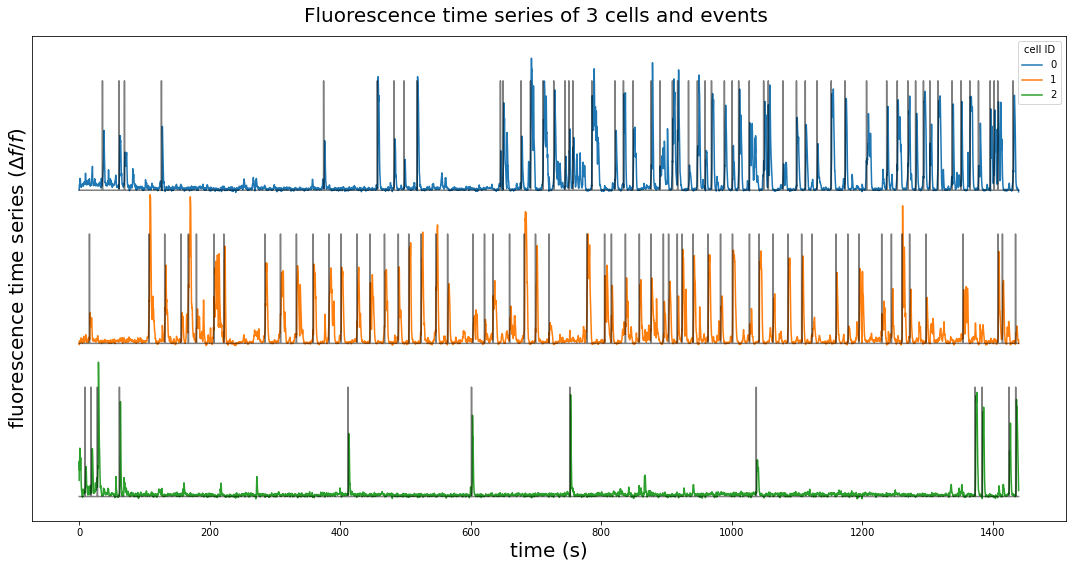

In [9]:
events = find_ev(dFonF_d)

fig,ax1 = plt.subplots(figsize=(15,8))
for i in range(len(cell_ID)):
    ax1.plot(t,dFonF[cell_ID[i],:]-offset*i,label=str(cell_ID[i]))
    ev = events[cell_ID[i],:]
    ax1.plot(t,50*ev-offset*i,'k',alpha=0.5)
ax1.set_yticks([])
ax1.set_xlabel('time (s)',fontsize=20)
ax1.set_ylabel("fluorescence time series ($\Delta f/f$)",fontsize=20)
ax1.legend(title='cell ID',loc='upper right')
plt.suptitle('Fluorescence time series of 3 cells and events',fontsize=20)
plt.tight_layout()
plt.show()

The raw fluorescence data is plotted in color above. We have superimposed in dark line the binary events.
## 2. Response and rastergram
### 2.1. Number of trials
We create a new variable containing the number of loops, using the phi variable (angular position of the mouse).

In [10]:
diff = np.zeros((N-1,1))
diff[(phi[1:]-phi[:-1])>350]=1    # new loop
diff[(phi[1:]-phi[:-1])<-350]=-1  # mouse going backwards to previous circle
trials = np.zeros((N-1,1))
for i in range(1,N-1):
    trials[i]=trials[i-1]+diff[i]

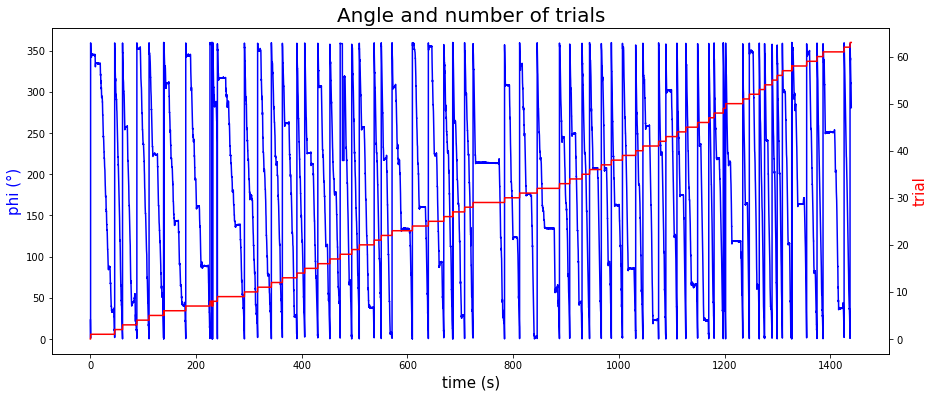

In [11]:
fig,ax = plt.subplots(figsize=(15,6))
ax.plot(t,phi,'b')
ax.set_xlabel('time (s)',fontsize=15)
ax.set_ylabel('phi (°)',fontsize=15)
ax.yaxis.label.set_color('b')
ax2=ax.twinx()
ax2.plot(t[:-1],trials,'r')
ax2.set_ylabel('trial',fontsize=15)
ax2.yaxis.label.set_color('red')
plt.title('Angle and number of trials',fontsize=20)
plt.show()

The blue line corresponds to the angular position of the mouse and the red line indicates the corresponding loop number (trial).
### 2.2. Response function
We write a function which returns the data for a cell in the form response(ID,trial,position), where ID indicates the cell ID, trial indicates which loop around the track the mouse is on, and position indicates the binned spatial angle of the mouse’s location, and response is 0 or 1. $binw$ coresponds to the bin width of the spatial angle bins (in degrees).

In [12]:
def response(ID,trial,position,binw=18):
    pos=binw*(position//binw)
    phi_=binw*(phi//binw)
    cell_events=events[ID,:]
    trial_ind=np.asarray(np.where(trials==trial)[0])
    pos_ind=np.asarray(np.where(phi_==pos)[0])
    both = set(trial_ind).intersection(pos_ind)
    if both==set():
        print('(trial',trial,'; position',position,'degrees, does not exist)')
    else:
        print('(trial',trial,'; position',position,'degrees )')
        if 1 in cell_events[np.array(list(both))]:
            return 1
        else:
            return 0

In [13]:
r=response(1,6,23)
print(r)
r=response(1,40,115)
print(r)
r=response(1,40,120)
print(r)

(trial 6 ; position 23 degrees )
1
(trial 40 ; position 115 degrees )
0
(trial 40 ; position 120 degrees )
0


Three example of the response function for cell ID=1 are shown above.
### 2.3. Rastergram function
The following functions extracts the phi values and the number of the trial when there is a firing event. We then plot the computed rastergram for the three first cells.

In [14]:
def raster(ID,events):
    cell_events=events[ID,:]
    PHI=phi[cell_events==1]
    TRIAL=trials[cell_events[:-1]==1]
    return PHI,TRIAL

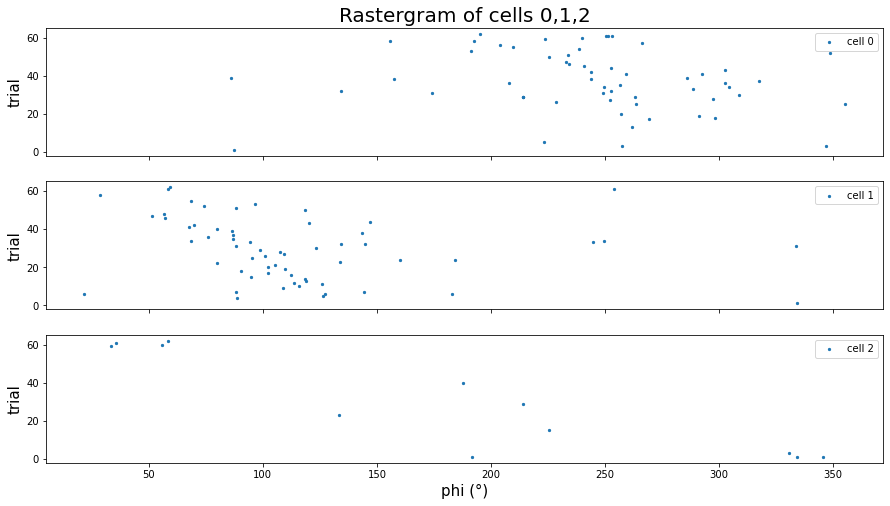

In [15]:
fig,(ax1,ax2,ax3)=plt.subplots(3,1,figsize=(15,8),sharex=True)
i=0
for ax in [ax1,ax2,ax3]:
    ID=cell_ID[i]
    PHI,TRIAL=raster(ID,events)
    ax.scatter(PHI,TRIAL,s=5)
    ax.set_ylabel("trial",fontsize=15)
    ax.legend(["cell "+str(ID)])
    i+=1
ax3.set_xlabel('phi (°)',fontsize=15)
ax1.set_title('Rastergram of cells 0,1,2',fontsize=20)
plt.show()

We observe that :
- cell 1 has a high selectivity of firing : most of the events occurs when phi approximately equals 100 degrees.
- cell 0 has a medium selectivity of firing : the dots are more scattered around a phi of approximately 250 degrees.
- cell 2 has a low selectivity of firing : the dots seems randomly distributed

## 3. Mutual information
### 3.1. Probability function

The function below counts the number of events in each bin of angular position. It also computes the probability density function.

In [16]:
def P(array,nbins):
    count,bins = np.histogram(array,bins=nbins)
    if count.sum()!=0:
        return count,count/count.sum(),bins

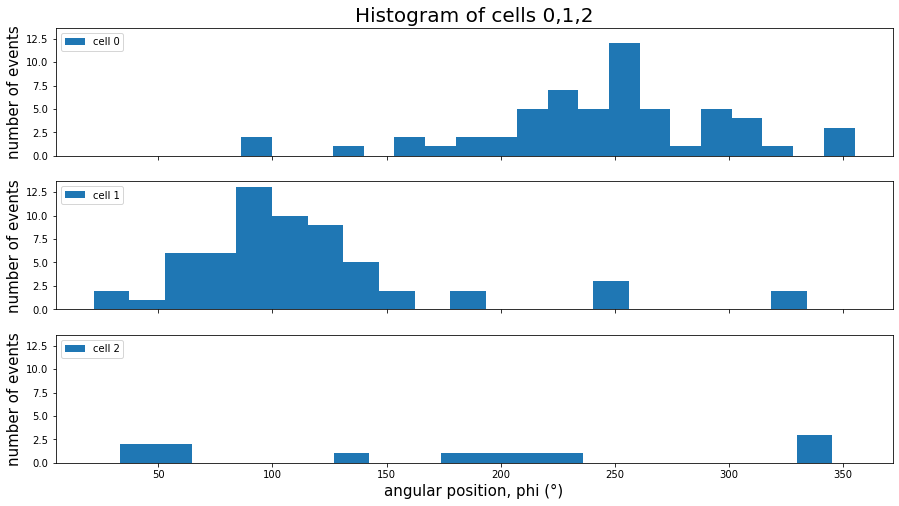

In [17]:
nbin=20
fig,(ax1,ax2,ax3)=plt.subplots(3,1,figsize=(15,8),sharex=True,sharey=True)
i=0
for ax in [ax1,ax2,ax3]:
    ID=cell_ID[i]
    cell_events=events[ID,:]
    count,p_phi1,bins=P(phi[cell_events==1],nbin)
    ax.stairs(count,bins,fill=True)
    ax.set_ylabel('number of events',fontsize=15)
    ax.legend(["cell "+str(ID)],loc="upper left")
    i+=1
ax3.set_xlabel('angular position, phi (°)',fontsize=15)
ax1.set_title('Histogram of cells 0,1,2',fontsize=20)
plt.show()

The above confirms what was observed in previous section :
- cell 1 has a high selectivity of firing : most of the events occurs when phi approximately equals 100 degrees.
- cell 0 has a medium selectivity of firing : the events are more scattered around a phi of approximately 250 degrees.
- cell 2 has a low selectivity of firing : the events seems randomly distributed

### 3.2. Entropy function

The entropy is given by the following formula:

$H(X)=- \sum_{p(X)\neq 0} p(X) \times log_2 \big( p(X) \big) $

with $p(X)$ the probability that the event $X$ occurs.
Given this formula we can then write the following function:

In [18]:
def H(p):
    p0=p[p!=0]
    H=-np.sum(p0*np.log2(p0))
    return H

In [19]:
for ID in cell_ID:
    cell_events=events[ID,:]
    count1,p_phi1,bins1=P(phi[cell_events==1],20)
    print("cell",ID,": H(phi|r=1)=",H(p_phi1))

cell_events=events[1,:]
_,p_r,_=P(cell_events,2)
print("cell",1,": H(r)=",H(p_r))

cell 0 : H(phi|r=1)= 3.618938169903989
cell 1 : H(phi|r=1)= 3.2219111034162826
cell 2 : H(phi|r=1)= 2.8553885422075336
cell 1 : H(r)= 0.0150076645581763


Some example of entropy calculation are shown above.

If we consider the distribution of the angular positions, knowing that an event has occured ($p(\phi|r=1)$), we observe that the entropy is lower for cell 1 than cell 0. This is due to the fact that the angular values are more scattered for cell 0. When we consider cell 1, we are more certain of the angular value at which an event is going to happen than with cell 0, so entropy is reduced.

The entropy of cell 2 is even lower, but it is due to very low amount of events so this value is biased.

### 3.3. Joint probability function
The function below computes the joint probabilities of $\phi$ and $r$ that will be useful in the calculation of mutual information.

In [20]:
def PXY(phi,cell_events):
    count0,p_phi0,bins0=P(phi[cell_events==0],20)
    count1,p_phi1,bins1=P(phi[cell_events==1],20)
    count=np.vstack((count0,count1))
    return count/count.sum()

cell_events=events[1,:]
print(PXY(phi,cell_events))
print('shape :',PXY(phi,cell_events).shape)
print('sum :',PXY(phi,cell_events).sum())

[[3.78256963e-02 5.27178796e-02 5.75471698e-02 4.20485175e-02
  4.50808625e-02 2.67295597e-02 5.10332435e-02 6.32973944e-02
  4.27448338e-02 6.14330638e-02 3.35354897e-02 7.77628032e-02
  6.53863432e-02 5.46945193e-02 4.78436658e-02 3.11096137e-02
  4.66981132e-02 5.08086253e-02 3.81401617e-02 7.21922731e-02]
 [4.49236298e-05 2.24618149e-05 1.34770889e-04 1.34770889e-04
  2.92003594e-04 2.24618149e-04 2.02156334e-04 1.12309075e-04
  4.49236298e-05 0.00000000e+00 4.49236298e-05 0.00000000e+00
  0.00000000e+00 0.00000000e+00 6.73854447e-05 0.00000000e+00
  0.00000000e+00 0.00000000e+00 0.00000000e+00 4.49236298e-05]]
shape : (2, 20)
sum : 1.0


The joint probabilities of $\phi$ and $r$ for cell ID=1 are shown above.
### 3.4. Mutual information function
The mutual information function of $\phi$ and $r$ is a measure of mutual dependance between the two variables. Multiple methods for the mutual information computation exists. We will be using the two following ones:

(a)    $I(\phi,r)=\sum P(\phi,r) \times log_2 \big( \frac{P(\phi,r)}{P(\Phi)P(r)} \big)$

(b)    $I(\phi,r)=H(\phi)+H(r)-H(\phi,r)$

In [21]:
def Ia(cell_events):
    _,p_phi,_=P(phi,20)
    _,p_r,_=P(cell_events,2)
    p_phi_r=PXY(phi,cell_events)
    prod=np.vstack((p_r[0]*p_phi,p_r[1]*p_phi))
    prod0=prod[p_phi_r!=0]
    p_phi_r0=p_phi_r[p_phi_r!=0]
    return sum(p_phi_r0*np.log2(p_phi_r0/prod0))

def Ib(cell_events):
    _,p_phi,_=P(phi,20)
    _,p_r,_=P(cell_events,2)
    p_phi_r=PXY(phi,cell_events)
    return H(p_phi)+H(p_r)-H(p_phi_r)

In [22]:
for ID in cell_ID:
    cell_events=events[ID,:]
    print(ID, ": I(phi,r)=",Ia(cell_events),"(a), or I(phi,r)=",Ib(cell_events),"(b).")
    print("   relative gap :",abs(int(100*(Ia(cell_events)-Ib(cell_events))/Ib(cell_events))),"%")

0 : I(phi,r)= 0.0008923349578706475 (a), or I(phi,r)= 0.000805733969375666 (b).
   relative gap : 10 %
1 : I(phi,r)= 0.001743766440919979 (a), or I(phi,r)= 0.0018046236598108223 (b).
   relative gap : 3 %
2 : I(phi,r)= 0.0003566978460713018 (a), or I(phi,r)= 0.0004035211937321037 (b).
   relative gap : 11 %


Cell 1 has more mutual information than cell 0. Again, this is due to a distribution of the firing events according to the position angle. Cell 2 has the lowest mutual information.

## 4. Bias on mutual information
### 4.1. Mutual information bias function

$B(I)=\frac{1}{2N_s ln(2)} \times \big( \sum (\bar{R_s} -1) -(R-1) \big)$

with $N_s$ the number of samples

and $\bar{R_s}$ the number of relevant responses for the stimulus conditional response probability distribution	$p(r|s)$, i.e. the number of different responses r with	non-zero probability of	being observed when	stimulus s is presented. So in the case of the study the list of $\bar{R_s}$ will be a list of 1 and 2 of length 20.

and $R$ the number of possible response: 2 (0 or 1)

In [23]:
def B(cell_events):
    count1,_,_=P(phi[cell_events==1],20)        # list of number of firing events per bin of angular position
    R_s_list = 2*(count1!=0) + 1*(count1==0)    # if 0 events => 1 response (0), if >0 events => 2 responses possible (0;1)
    R = 2                                       # number of possible response
    Ns=20*trials.max()                          # number of samples
    return (sum(R_s_list-1)-(R-1))/(2*Ns*np.log(2))

In [24]:
for ID in cell_ID:
    cell_events=events[ID,:]
    print(ID, ": bias=",B(cell_events))

0 : bias= 0.008587470481481925
1 : bias= 0.006297478353086745
2 : bias= 0.004007486224691565


The cells that are the less likely to be biased are:
- cells with high selectivity of firing: (cell 1) as this cell has a lot mutual information, the number of possible response by angular position sample is equal to one for most of the samples and two for only a few samples. As a result, the sum of the possible response array is relatively low
- cells with low selectivity of firing: (cell 2) as this cell has very few firing events, the sum of the possible response array is very low

The cells that are the more likely to be biased are:
- cells with medium selectivity of firing: (cell 0) the number of possible response by angular position sample is equal to two for a lot more samples than cell 1. As a result, the sum of the possible response array is higher than for cell 1.

## 5. Spatial information rate
### 5.1. Mutual information and bias of all the cells
The following loop calculate the mutual information anf bias for each cell of the dataset:

In [25]:
I_list=np.zeros((n))       # mutual information list
B_list=np.zeros((n))       # bias list
for ID in range(n):
    cell_events=events[ID,:]
    if cell_events.sum()!=0:
        I_list[ID]=Ia(cell_events)
        B_list[ID]=B(cell_events)

looptime=t[-1]/trials.max()     # average time for the mouse to make a loop
bin_width=looptime/20
I_rate=I_list/bin_width

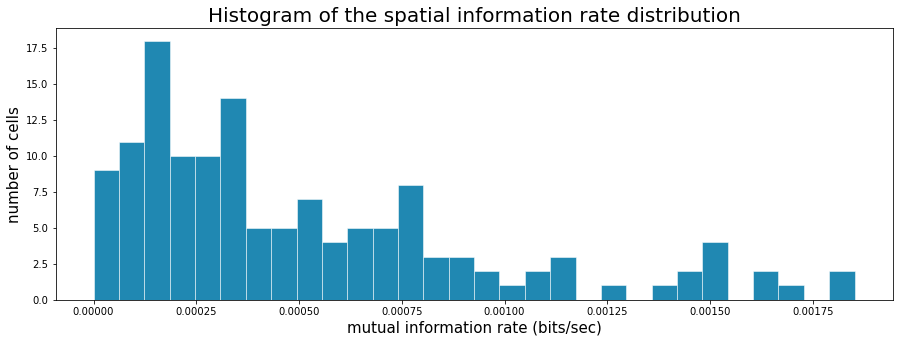

In [26]:
fig,ax=plt.subplots(figsize=(15,5))
ax.hist(I_rate,density=False,bins=30, facecolor = '#2088B2', edgecolor='#FFFFFF', linewidth=0.5)
plt.xlabel('mutual information rate (bits/sec)', fontsize=15)
plt.ylabel('number of cells', fontsize=15)
plt.title('Histogram of the spatial information rate distribution',fontsize = 20)
plt.show()

To obtain the mutual information rate, we divided the mutual information of all the cells by the bin width in seconds. We can observe that a few cells have a high mutual information rate. They can be qualified as high selectivity place cells.
### 5.2. Cell with the highest spatial information rate

spatial information rate of cell 4  : I_r = 0.0018518278013270912 bits/sec


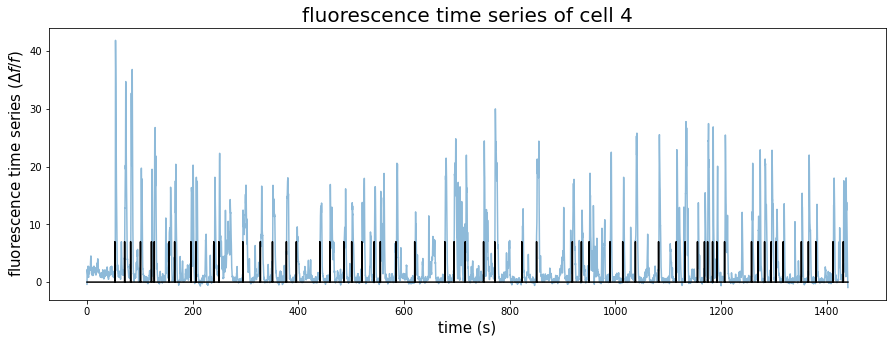

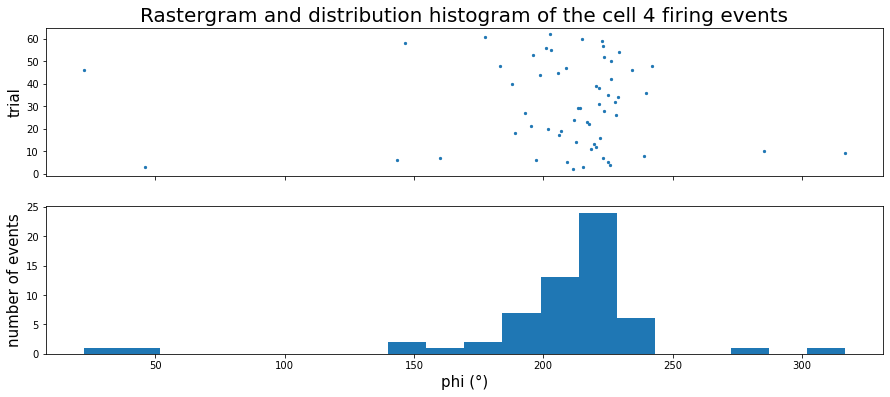

In [27]:
ID=np.argmax(I_rate)                                     # indice of the highest spatial information rate cell
print("spatial information rate of cell "+str(ID)," : I_r =",I_rate[ID],'bits/sec')
PHI,TRIAL=raster(ID,events)                              # angles and trials numbers of the firing events
cell_events=events[ID,:]                                 # cell events array of the cell
count,p_phi1,bins=P(phi[cell_events==1],20)              # probability density function of the firing events p(phi|r=1)

fig,ax0=plt.subplots(figsize=(15,5))
ax0.plot(t,dFonF[ID,:],alpha=0.5)
ax0.plot(t,7*cell_events,'k')
ax0.set_xlabel('time (s)',fontsize=15)
ax0.set_ylabel("fluorescence time series ($\Delta f/f$)",fontsize=15)
plt.title('fluorescence time series of cell '+str(ID),fontsize=20)
plt.show()

fig,(ax1,ax2)=plt.subplots(2,1,figsize=(15,6),sharex=True)

ax1.scatter(PHI,TRIAL,s=5)
ax1.set_ylabel('trial',fontsize=15)
ax1.set_title('rastergram of cells 1',fontsize=20)

ax2.stairs(count,bins,fill=True)
ax2.set_ylabel('number of events',fontsize=15)
ax2.set_xlabel('phi (°)',fontsize=15)
ax1.set_title('Rastergram and distribution histogram of the cell '+str(ID)+ ' firing events',fontsize=20)
plt.show()

We can observe on the histogram that the values are much tighter around the central value. The higher the spatial information rate is, the higher the selectivity of the cell is.